# Import Dependencies

In [37]:
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

from tensorflow.keras.models import Model, Sequential
from keras.layers import (Input,
                          LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# EDA

In [3]:
df = pd.read_csv('../data/training.csv', header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')

In [4]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.shape

(1600000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df = df[['text', 'target']]

In [8]:
df.text = df.text.astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  string
 1   target  1600000 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 24.4 MB


In [9]:
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
df.target.unique()

array([0, 4], dtype=int64)

In [11]:
df = df.replace(to_replace=4, value=1)
df.target.unique()

array([0, 1], dtype=int64)

In [12]:
df[df.target==0]

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
799995,Sick Spending my day laying in bed listening ...,0
799996,Gmail is down?,0
799997,rest in peace Farrah! So sad,0
799998,@Eric_Urbane Sounds like a rival is flagging y...,0


In [13]:
df[df.target==1]

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [14]:
# The first half of the dataset has target 0 and the second half has target 1,
# let's shaffle it

df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,target
0,@aaroncarter7 u never got back to me about the...,0
1,"Not the greatest game of bowling ever, but not...",1
2,@thestuntdude where u @ homie no tweets?,0
3,Boring housework this morning,0
4,@BedlamB that is a sad story I like how you g...,0


In [15]:
df[df.text.str.len() > 280].sum()

target    15
dtype: int64

In [16]:
df = df[df.text.str.len() <= 280]

Text(0.5, 0.98, 'Number of Characters in Tweets')

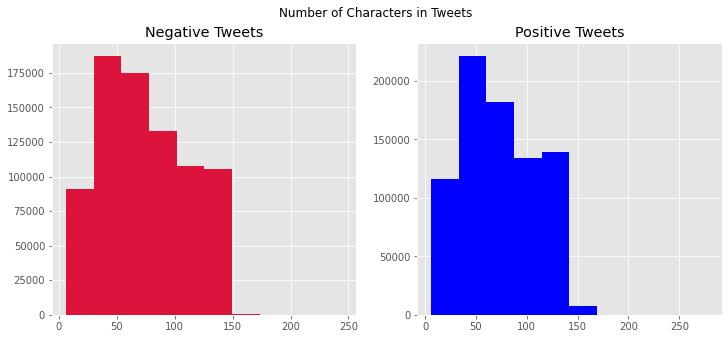

In [17]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))

tweets_negative_len = df[df.target == 0].text.str.len()

ax1.hist(tweets_negative_len, color='crimson')
ax1.set_title('Negative Tweets')

tweets_positive_len = df[df.target == 1].text.str.len()

ax2.hist(tweets_positive_len, color='blue')
ax2.set_title('Positive Tweets')

fig.suptitle('Number of Characters in Tweets')

In [18]:
df.shape[0]

1599982

In [19]:
300000/df.shape[0]

0.18750210939873074

In [20]:
print(df.target.isnull().values.any())
print(df.text.isnull().values.any())

False
False


In [21]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
# Applying the cleaning function to both test and training datasets
df.text = df.text.apply(lambda x: clean_text(x))

In [23]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [24]:
# Applying the function to both test and training datasets
df.text = df.text.apply(lambda x: remove_emoji(x))

# Let's take a look at the updated text
df.text.head()

0     u never got back to me about the internshipjo...
1    not the greatest game of bowling ever but not ...
2                            where u  homie no tweets 
3                       boring housework this morning 
4     that is a sad story  i like how you got all t...
Name: text, dtype: object

# Build Model

In [25]:
tweets = df.text.values
sentiments = df.target.values

In [26]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweets)
vocab_length = len(word_tokenizer.word_index) + 1

In [38]:
# Save the tokenizer to a file
with open('./saved_tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [16]:
length_long_sentence = 280
padded_sentences = pad_sequences(embed(tweets), length_long_sentence, padding='post')

In [20]:
def read_glove_file(glove_file):
    with open(glove_file, encoding='cp437') as f:
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map

In [21]:
# You can find the GloVe file at https://nlp.stanford.edu/projects/glove/
embedding_dim = 100
embedding_dict = read_glove_file('../data/glove.twitter.27B.100d.txt')

In [22]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

In [23]:
for word, index in word_tokenizer.word_index.items():
  embedding_vect = embedding_dict.get(word)
  if embedding_vect is not None:
    embedding_matrix[index] = embedding_vect

In [35]:
print("The number of rows with only zeros is:", sum(np.all(embedding_matrix, axis=1)) / embedding_matrix.shape[0])

The number of rows with only zeros is: 0.3047134113883958


In [24]:
# Let's split the datasat in training, developing and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=(300000/df.shape[0])
)

In [25]:
X_dev, X_test = np.split(X_test, 2, axis=0)
y_dev, y_test = np.split(y_test, 2, axis=0)

In [38]:
print(X_test.shape)
print(X_dev.shape)
print(y_dev.shape)
print(y_test.shape)

(150000, 280)
(150000, 280)
(150000,)
(150000,)


In [26]:
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_dev.shape)
print(y_test.shape)

(150000, 1)
(150000, 1)


In [40]:
print("Number of training samples:", X_train.shape[0])
print("Number of develop samples:", X_dev.shape[0])
print("Number of testing samples:", X_test.shape[0])

Number of training samples: 1299982
Number of develop samples: 150000
Number of testing samples: 150000


In [27]:
def model():
    input_layer = Input(shape=(length_long_sentence,))
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix], 
                        input_length=length_long_sentence)(input_layer)
    lstm_layer = Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0))(embedding_layer)
    pool_layer = GlobalMaxPool1D()(lstm_layer)
    norm_layer = BatchNormalization()(pool_layer)
    dropout_layer1 = Dropout(0.5)(norm_layer)
    dense_layer1 = Dense(length_long_sentence, activation="relu")(dropout_layer1)
    dropout_layer2 = Dropout(0.5)(dense_layer1)
    dense_layer2 = Dense(length_long_sentence, activation="relu")(dropout_layer2)
    dropout_layer3 = Dropout(0.5)(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer3)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
model = model()
checkpoint = ModelCheckpoint(
    'model_3epochs.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 8, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 3,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/3
40625/40625 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7925
Epoch 1: val_loss improved from inf to 0.69557, saving model to model_3epochs.h5
40625/40625 [==============================] - 2365s 58ms/step - loss: 0.4778 - accuracy: 0.7925 - val_loss: 0.6956 - val_accuracy: 0.8051 - lr: 0.0010
Epoch 2/3
40625/40625 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8092
Epoch 2: val_loss improved from 0.69557 to 0.41643, saving model to model_3epochs.h5
40625/40625 [==============================] - 2373s 58ms/step - loss: 0.4602 - accuracy: 0.8092 - val_loss: 0.4164 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 3/3
40624/40625 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8127
Epoch 3: val_loss improved from 0.41643 to 0.41466, saving model to model_3epochs.h5
40625/40625 [==============================] - 2363s 58ms/step - loss: 0.4531 - accuracy: 0.8127 - val_loss: 0.4147 - val_accuracy: 0.8154 - lr: 0.0

In [94]:
preds = model.predict(X_dev)
preds = np.around(preds)
metrics(preds, y_dev)

4688/4688 [==============================] - 82s 17ms/step
F1-score:  0.8071711370099817
Precision:  0.7722883209731634
Recall:  0.8453542019505927
Acuracy:  0.8155733333333334
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82     81508
         1.0       0.77      0.85      0.81     68492

    accuracy                           0.82    150000
   macro avg       0.82      0.82      0.82    150000
weighted avg       0.82      0.82      0.82    150000



In [32]:
preds = model.predict(X_test)
preds = np.around(preds)
metrics(preds, y_test)

4688/4688 [==============================] - 86s 18ms/step
F1-score:  0.8076284433945877
Precision:  0.7734985294704763
Recall:  0.8449092917781137
Acuracy:  0.8154066666666666
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82     81208
         1.0       0.77      0.84      0.81     68792

    accuracy                           0.82    150000
   macro avg       0.82      0.82      0.82    150000
weighted avg       0.82      0.82      0.82    150000



In [40]:
# example input tweet
input_tweet = "This app is great"

# preprocess the input tweet
input_tweet = clean_text(input_tweet) 

input_sequence = word_tokenizer.texts_to_sequences([input_tweet])
padded_sequence = pad_sequences(input_sequence, maxlen=280, truncating='post')

# predict the sentiment probabilities
sentiment_probs = model.predict(padded_sequence)

# convert the sentiment probabilities to a sentiment label
sentiment_label = np.around(sentiment_probs)[0][0]
print(f"The sentiment of the tweet is {sentiment_label}.")

1/1 [==============================] - 0s 27ms/step
The sentiment of the tweet is 1.0.
